# Building metacells with [SEACell](https://github.com/dpeerlab/SEACells)

An example of building *metacells* using the [SEACell](https://github.com/dpeerlab/SEACells) algorithm. 
 
**Data:** cell lines scRNA-seq from [Tian et. al, 2019](https://doi.org/10.1038/s41592-019-0425-8), the same as for the [first tutorial](https://github.com/GfellerLab/SIB_workshop/blob/main/workbooks/Cell_lines.md).

*.h5ad* anndata file with scRNA-seq data is located in `'data/cell_lines/anndata_filtered.h5ad'`

For the complete tutorial of metacell construction with the [SEACell](https://github.com/dpeerlab/SEACells), please, follow author's [tutorial](https://github.com/dpeerlab/SEACells/blob/main/notebooks/SEACell_computation.ipynb) and the [readme](https://github.com/dpeerlab/SEACells/blob/main/README.md) for installation.


## Imports

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os

import SEACells

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


## Parameter
Requested graining level

In [2]:
gamma = 20 # graining level

## Load data

In [3]:
# Load data pre-filtered data
proj_name = "cell_lines"
data_folder = os.path.join("../data/", proj_name)
ad = sc.read(os.path.join(data_folder, "anndata_filtered.h5ad"))

## Data processing 
In contrast to [Metacell-2](), SEACells build metacells based on processed data and takes as an input dimensionally reduced data (i.e., PCA for scRNA-seq data). Thus, we first compute PCA for our data usign the same set of genes used in the main [tutorial]()

In [4]:
# Save count as a separate layer
ad.layers['counts'] = ad.X

# Copy the counts to ".raw" attribute of the anndata since it is necessary for downstream analysis
# This step should be performed after filtering 
raw_ad = sc.AnnData(ad.layers['counts'])
raw_ad.obs_names, raw_ad.var_names = ad.obs_names, ad.var_names
ad.raw = raw_ad

In [5]:
# Normalize cells, log transform and compute highly variable genes
sc.pp.normalize_per_cell(ad)
sc.pp.log1p(ad)
sc.pp.highly_variable_genes(ad, n_top_genes=1000)

# set HVG manually (to be consistent with the main tutorial). If you want to use the HVG set computed by Scanpy, comment this line
ad.var['highly_variable'] = ad.var['use_for_SC_construction'].copy()

In [6]:
# Compute principal components - 
# Here we use 10 components to be consistent with out main tutorial, but fill free to explore other number of principal components to use 

n_comp    = 10
sc.tl.pca(ad, n_comps=n_comp, use_highly_variable=True)

# Compute UMAP for visualization 
sc.pp.neighbors(ad, n_neighbors=10, n_pcs=n_comp)
sc.tl.umap(ad)

## Computing metacells 

In [7]:
## User defined parameters
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data
## Additional parameters
n_waypoint_eigs = 10      # Number of eigenvalues to consider when initializing metacells
waypoint_proportion = 0.9 # Proportion of metacells to initialize using waypoint analysis, 
                          # the remainder of cells are selected by greedy selection
    
n_iter = 20

In [8]:
# The number of SEACells is computed as a ratio between the number of single cells and the desired graining level
n_SEACells = int(ad.shape[0]/gamma) 

model = SEACells.core.SEACells(
    ad, 
    build_kernel_on=build_kernel_on, 
    n_SEACells=n_SEACells, 
    n_waypoint_eigs=n_waypoint_eigs,
    waypt_proportion=waypoint_proportion,
    convergence_epsilon = 1e-5
)


Building kernel...
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/3822 [00:00<?, ?it/s]

Making graph symmetric...
Computing RBF kernel...


  0%|          | 0/3822 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/3822 [00:00<?, ?it/s]

Constructing CSR matrix...


Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 156 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/45 [00:00<?, ?it/s]

Selecting 35 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.006680369913081166
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 20 iterations.


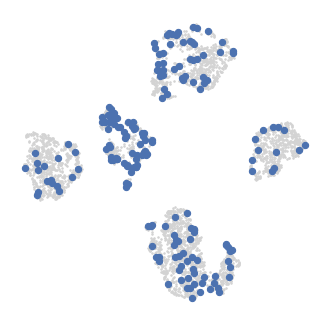

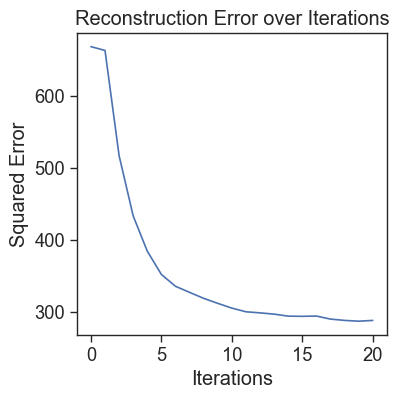

  0%|          | 0/191 [00:00<?, ?it/s]

/Users/mariiabilous/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/SEACells/core.py:558: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  meta_ad = sc.AnnData(csr_matrix(summ_matrix))


In [9]:
# Initialize archetypes
model.initialize_archetypes()
    
# Plot the initilization to ensure they are evenly spread
SEACells.plot.plot_initialization(ad, model, plot_basis='X_umap')
    
model.fit(n_iter = n_iter)
    
# Check for convergence 
model.plot_convergence()
    
membership = model.get_assignments()
    
SEACell_ad = SEACells.core.summarize_by_SEACell(ad, SEACells_label='SEACell', summarize_layer='raw')
    

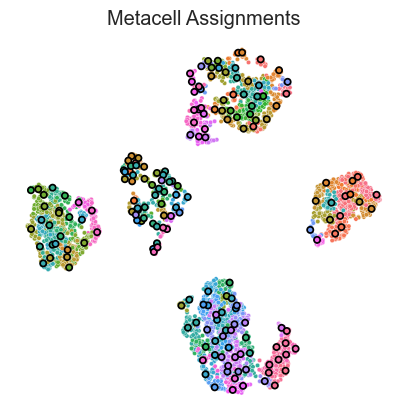

In [10]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=True)

In [11]:
d = {x: i+1 for i, x in enumerate(SEACell_ad.obs_names)}
# make a membership (as in SCimplify() from SuperCell) vector
ad.obs['membership'] = [d[x] for x in membership.SEACell]

## Save single-cell metadata (i.e., `ad.obs` dataframe) in the seacell adata object
SEACell_ad.uns = ad.uns.copy()
SEACell_ad.uns['sc.obs'] = ad.obs.copy()

SEACell_ad.var['feature_gene'] = ad.var['highly_variable'].astype(int)

## Saving data for the downstream analysis

In [12]:
SEACell_ad.write(os.path.join(data_folder, 'output', f'seacells_gamma_{gamma}.h5ad'))
#ad.obs.to_csv(os.path.join(data_folder, 'output', f'seacells_gamma_{gamma}.csv'))
